In [1]:
import networkx as nx
from scipy import linalg as ln
import numpy as np
import time
import matplotlib.pyplot as plt
from statistics import mean
import os
import csv


from OperatorBenchmark2 import OperatorBenchmark2

In [2]:
n = 1500
t = 500
graph = nx.cycle_graph(n)

benchmark = OperatorBenchmark2(graph)

# Time the buildDiagonalOperator method
start_time = time.time()
benchmark.buildDiagonalOperatorEig(graph)
end_time = time.time()
print(f"Time taken for buildDiagonalOperator: {end_time - start_time} seconds")

# Time the buildSlowDiagonalOperator method
start_time = time.time()
benchmark.buildSlowDiagonalOperator(graph)
end_time = time.time()
print(f"Time taken for buildSlowDiagonalOperator: {end_time - start_time} seconds")

Time taken for buildDiagonalOperator: 1.0910017490386963 seconds
Time taken for buildSlowDiagonalOperator: 0.06399822235107422 seconds


Graph Sizes: [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771, 781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891, 901, 911, 921, 931, 941, 951, 961, 971, 981, 991]
Fast Times: {1: 1.680001732893288e-05, 11: 1.738998107612133e-05, 21: 2.6890001026913524e-05, 31: 4.959999350830913e-05, 41: 4.7609995817765594e-05, 51: 5.7990005007013676e-05, 61: 6.972999544814229e-05, 71: 8.818000787869096e-05, 81: 0.00011245001223869622, 91: 0.00012565000797621907, 101: 0.00015026999753899872, 111: 0.00017079999670386315, 121: 0.00020834000315517187, 131: 0.00021677000331692397, 141: 0.0002427400031592697, 151: 0.00028965999954380097, 161: 0.00041599000687710943, 171: 0.0

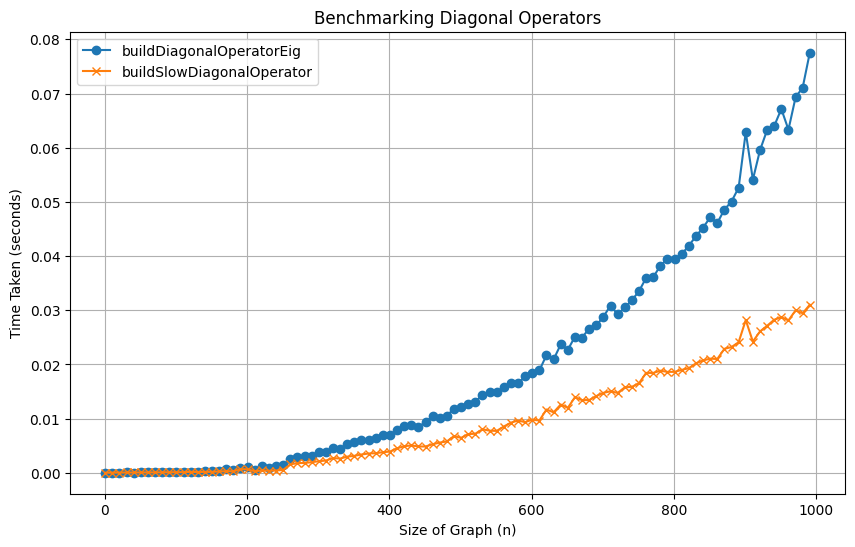

In [27]:
def calculate_multiple_n(start, stop, step, sample, filename):
    graph_sizes = []

    fast_filename = filename + "_fast_times.csv"
    slow_filename = filename + "_slow_times.csv"
    graph_sizes_filename = filename + "_graph_sizes.csv"

    with open(fast_filename, 'w') as fast_f, open(slow_filename, 'w') as slow_f, open(graph_sizes_filename, 'w') as graph_f:
        fast_f.write("Graph Size,Sample,Fast Time\n")  # Write the header for fast times
        slow_f.write("Graph Size,Sample,Slow Time\n")  # Write the header for slow times
        graph_f.write("Graph Size\n")  # Write the header for graph sizes

        for n in range(start, stop + 1, step):
            graph = nx.cycle_graph(n)
            benchmark = OperatorBenchmark2(graph)

            # Warm-up runs (not timed)
            for _ in range(3):
                benchmark.buildDiagonalOperatorNoEig(graph)
                benchmark.buildSlowDiagonalOperator(graph)

            for s in range(sample):
                # Time the buildDiagonalOperatorEig method
                start_time = time.perf_counter()
                benchmark.buildDiagonalOperatorNoEig(graph)
                end_time = time.perf_counter()
                fast_time = end_time - start_time

                # Write the data to the fast times file
                fast_f.write(f"{n},{s},{fast_time}\n")

                # Time the buildSlowDiagonalOperator method
                start_time = time.perf_counter()
                benchmark.buildSlowDiagonalOperator(graph)
                end_time = time.perf_counter()
                slow_time = end_time - start_time

                # Write the data to the slow times file
                slow_f.write(f"{n},{s},{slow_time}\n")

            graph_sizes.append(n)
            graph_f.write(f"{n}\n")

    return graph_sizes

def load_times_from_file(filename):
    fast_filename = filename + "_fast_times.csv"
    slow_filename = filename + "_slow_times.csv"
    graph_sizes_filename = filename + "_graph_sizes.csv"

    fast_times = {}
    slow_times = {}
    graph_sizes = []

    # Load fast times and calculate mean
    with open(fast_filename, 'r') as fast_f:
        csv_reader = csv.reader(fast_f)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            graph_size, sample, fast_time = int(row[0]), int(row[1]), float(row[2])
            if graph_size not in fast_times:
                fast_times[graph_size] = []
            fast_times[graph_size].append(fast_time)

        for size in fast_times:
            fast_times[size] = sum(fast_times[size]) / len(fast_times[size])

    # Load slow times and calculate mean
    with open(slow_filename, 'r') as slow_f:
        csv_reader = csv.reader(slow_f)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            graph_size, sample, slow_time = int(row[0]), int(row[1]), float(row[2])
            if graph_size not in slow_times:
                slow_times[graph_size] = []
            slow_times[graph_size].append(slow_time)

        for size in slow_times:
            slow_times[size] = sum(slow_times[size]) / len(slow_times[size])

    # Load graph sizes
    with open(graph_sizes_filename, 'r') as graph_f:
        csv_reader = csv.reader(graph_f)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            graph_sizes.append(int(row[0]))

    return graph_sizes, fast_times, slow_times

start = 100
stop = 1000
step = 100
samples = 5
filename =  f'TestOutput/OperatorBenchmark/benchmark_F{start}_T{stop}_ST{step}'

graph_sizes = calculate_multiple_n(start, stop, step, samples, filename)
graph_sizes, fast_times, slow_times = load_times_from_file(filename)


def plot_benchmark(graph_sizes, fast_times, slow_times):
    print("Graph Sizes:", graph_sizes)
    print("Fast Times:", fast_times)
    print("Slow Times:", slow_times)

    plt.figure(figsize=(10, 6))
    fast_times_list = [fast_times[size] for size in graph_sizes]
    slow_times_list = [slow_times[size] for size in graph_sizes]
    plt.plot(graph_sizes, fast_times_list, label='buildDiagonalOperatorEig', marker='o')
    plt.plot(graph_sizes, slow_times_list, label='buildSlowDiagonalOperator', marker='x')
    plt.xlabel('Size of Graph (n)')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Benchmarking Diagonal Operators')
    plt.legend()
    plt.grid(True)
    plt.show()

start = 1
stop = 1000
step = 10
samples = 10
filename = f'TestOutput/OperatorBenchmark/benchmark_F{start}_T{stop}_ST{step}'

# Comment this line if you want to test only the loading and plotting functions
graph_sizes = calculate_multiple_n(start, stop, step, samples, filename)

graph_sizes, fast_times, slow_times = load_times_from_file(filename)

plot_benchmark(graph_sizes, fast_times, slow_times)

Now i want you to create a load function that first checks if a filename is present and prints if it found it or not. If it didnt find it, it should run the calculate_multiple_n. If it did find it, it should check if all the required timesteps are present (you can check if the total number of timesetps is equal to the stop variable) and print a message saying if all timesteps are present or not. If they are present then you can return the variables and print a success message. If they are not present you should run calculate_multiple_n from that point to the end, and then print a success message.